In [1]:
# The code was removed by Watson Studio for sharing.

### IMPORTANT: If you can't see the maps in this notebook, please make sure you open it in Firefox, as Chrome and Edge are known to have problems with Folium 

In [2]:
#download file from Cloud object storage
Bucket='****'
client_****.download_file(Bucket,Key='df_raw_cos.pkl',Filename='./df_raw_local.pkl')

df_complaint = pd.read_pickle('./df_raw_local.pkl')
df_complaint.shape

(5830085, 15)

In [3]:
#df_complaint.head()

In [4]:
#New York City Open Data data file web site indicated that the complaint type "HEAT/HOT Water" was renamed from "HEATING" after 2014. So we combine these two types into one

df_complaint['complaint_type'] = np.where(df_complaint['complaint_type']=='HEATING','HEAT/HOT WATER',df_complaint['complaint_type'])
#we check that indeed HEAT/HOT WATER is the most frequent complaint as we saw in Question 1
df_complaint['complaint_type'].value_counts().nlargest(n=5)



HEAT/HOT WATER          2035644
PLUMBING                 700177
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     430555
PAINT - PLASTER          361258
Name: complaint_type, dtype: int64

In [5]:
#we filter only the complaints type HEAT/HOT WATER in a new dataframe

df_ht_complaint = df_complaint[df_complaint['complaint_type'] == 'HEAT/HOT WATER']
df_ht_complaint=df_ht_complaint[::]

In [6]:
#we check for columns that most likely won't add any valuable information for our analysis (all their values are the same)
print(df_ht_complaint['address_type'].unique())
print(df_ht_complaint['location_type'].unique())

['ADDRESS' nan]
['RESIDENTIAL BUILDING']


In [7]:
#we drop unnecessary columns to reduce size of data. The columns underneath have only one value, so we can drop them
df_ht_complaint.drop(['complaint_type','location_type','address_type'],axis=1,inplace=True)

In [8]:
#there are also other columns we will not use for the analysis that we can drop to reduce size of data.
df_ht_complaint.drop(['city','status'],axis=1,inplace=True)

In [9]:
#drop rows with no created or closed date
df_ht_complaint.dropna(subset=['created_date','closed_date'],axis=0,inplace=True)
df_ht_complaint.shape

(2020703, 10)

We can use two criteria to decide in which areas to focus: Geographical concentration (that is boroughs, streets or ZIPs with the highest concentration of complaints), and the delays to solve the claims, that is which areas (again boroughs, streets or ZIPs) seem to take longest to close complaints. So let's add a column 'delay' with the time it takes to close complaints

In [10]:
#calculate delay to close complaints.Add new column
df_ht_complaint['delay']=df_ht_complaint['closed_date']-df_ht_complaint['created_date']
#convert delay into float (number of hours)
df_ht_complaint['delay']=df_ht_complaint['delay'].astype("timedelta64[h]")

In [11]:
#drop older rows. We want to focus on recent history. We also drop data from 2019, since it is not a complete year.
df_ht_complaint = df_ht_complaint[df_ht_complaint['created_date'] >= '2014']
df_ht_complaint = df_ht_complaint[df_ht_complaint['created_date'] < '2019']
df_ht_complaint =df_ht_complaint[::]

In [12]:
#we convert the incident zip value to string 
df_ht_complaint[['incident_zip']]=df_ht_complaint[['incident_zip']].astype(str)
#and remove the decimals
df_ht_complaint['incident_zip']=df_ht_complaint['incident_zip'].str[:-2]

In [13]:
#we also notice that some complaints are filed more than one time. lets drop complaints that are duplicates


df_ht_complaint= df_ht_complaint[~df_ht_complaint['resolution_description'].str.contains("duplicate")]

In [14]:
#after which we can drop the column resolution_description
df_ht_complaint.drop(['resolution_description'],axis=1,inplace=True)

In [15]:
df_ht_complaint.head()

created_date  unique_key incident_zip   incident_address  \
46260 2018-08-15 08:34:41    40020899        11433  153-16 SOUTH ROAD   
46262 2018-08-22 18:05:07    40079557        11433  153-16 SOUTH ROAD   
46263 2018-09-08 12:58:14    40228240        11433  153-16 SOUTH ROAD   
46264 2018-09-11 01:46:25    40246970        11433  153-16 SOUTH ROAD   
46313 2018-10-22 11:27:26    40625222        11433  153-16 SOUTH ROAD   

      street_name borough             latitude            longitude  \
46260  SOUTH ROAD  QUEENS               40.696              -73.800   
46262  SOUTH ROAD  QUEENS               40.696              -73.800   
46263  SOUTH ROAD  QUEENS               40.696              -73.800   
46264  SOUTH ROAD  QUEENS               40.696              -73.800   
46313  SOUTH ROAD  QUEENS               40.696              -73.800   

              closed_date                delay  
46260 2019-04-26 12:57:43            6,100.000  
46262 2019-04-26 12:57:43            5,922.000  
46263 2019-04-26 12:57:43            5,519.000  
46264 2019-04-26 12:57:43            5,459.000  
46313 2019-04-26 12:57:43            4,465.000

Let's start analyzing what happens in each Borough. First we look at the total number of complaints and how was the trend in the recent years

In [16]:
# a first attempt of addressing the question would be to check which boroughs have had overall the highest number of complaints. 

df_ht_complaint['borough'].value_counts()
#convert to DFrame
complaints_counts = df_ht_complaint['borough'].value_counts().to_frame()
#rename column with amount of complaints per type
complaints_counts.rename(columns={'borough': 'value_counts'}, inplace=True)
#rename index
complaints_counts.index.name = 'borough'
complaints_counts
#complaints_counts.plot(kind='bar')

value_counts
borough                    
BROOKLYN             235496
BRONX                222974
MANHATTAN            162701
QUEENS                95017
STATEN ISLAND          8282
Unspecified               1

We can see how the number of complaints is higher in Bronx and Brooklyn compared to the other boroughs. Note, however that this chart takes into account historical trends, so we could be masking recent problems, or the other way around, past problems now eventually solved could have increased significantly the overall count in a particular borough thus portraying a picture different from the current situation. So we should additionally look into the trend of complaints per borough per year to understand better the situation today

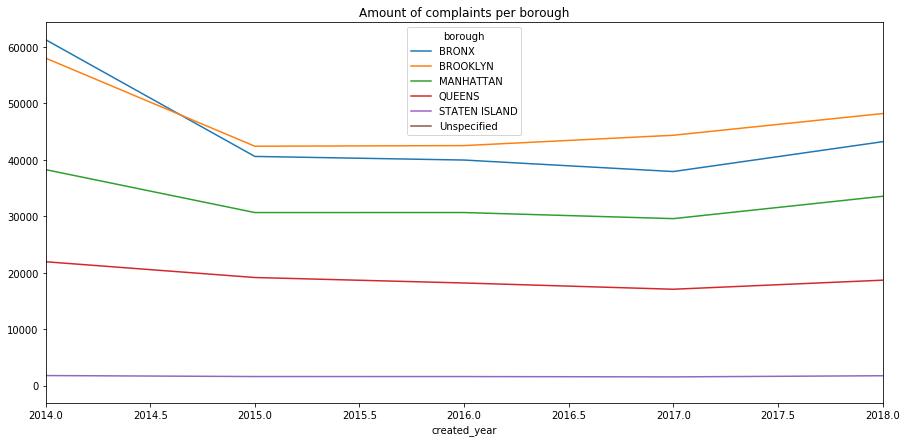

In [17]:
#let's now look at the historical trends per Borough to see if we can gain some insights.

#first we add columns to insert year and month of creation of the complaint
df_ht_complaint['created_year'] = df_complaint['created_date'].map(lambda x: x.strftime('%Y')).astype(int)
df_ht_complaint['created_month'] = df_complaint['created_date'].map(lambda x: x.strftime('%m')).astype(int)
#we countf_ht_complaint['complaint_type'].value_counts()

fig, ax = plt.subplots(figsize=(15,7))
df_ht_complaint.groupby(['created_year', 'borough']).count()['unique_key'].unstack().plot(ax=ax, title='Amount of complaints per borough')


By looking at the chart above, we have several findings. Boroughs with the highest number of complaints are consistently Bronx and Brooklyn. Looking at the trends per borough for the last 5 years it doesn't appear to be changes amongst them. They all suffered similar increase/decreases showing similar behaviour with time. Bronx and brooklyn have consistently much higher number of complaints.
    So based exclusively on amount of complaints, we can think of focusing more in BRONX and BROOKLYN. 
    
   HOWEVER WE ARE GOING TO CONFIRM THIS BY LOOKING ALSO AT THE TIME IT TAKES to CLOSE A COMPLAINT PER BOROUGH



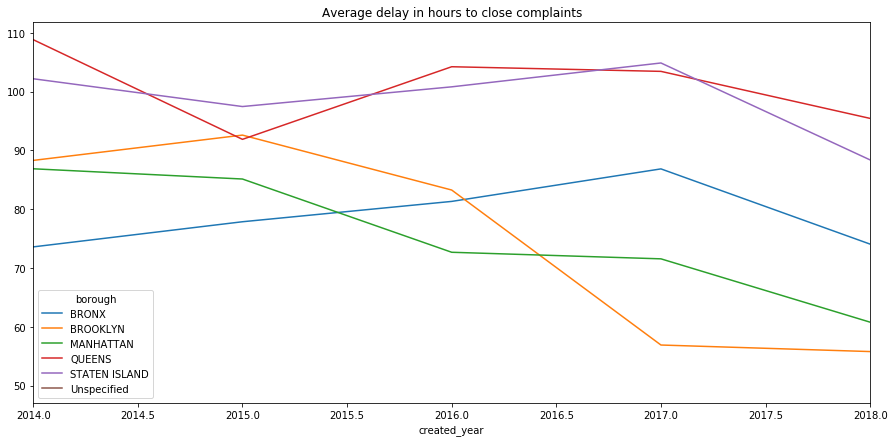

In [18]:
#let's look now at the evolution over time of the delay to close complaints per borough
fig, ax = plt.subplots(figsize=(15,7))
df_ht_complaint.groupby(['created_year', 'borough']).mean()['delay'].unstack().plot(ax=ax, title='Average delay in hours to close complaints')

We can see that both Manhattan and Brooklyn have significantly decreased their delay to close complaints in the past 5 years,while the rest of boroughs din't change significantly since 2015. So instead of analyzing the complaints over the whole period of time, we should better focus on the most recent history (2017-2018)in order not to distort the current situation

Let's take a look more in detail at what happened in 2017 and 2018

In [19]:
#drop older rows. We want to focus on recent history
df_ht_complaint_recent = df_ht_complaint[df_ht_complaint['created_year'].isin(['2017','2018'])]
df_ht_complaint_recent =df_ht_complaint_recent[::]

 Number of complaints per borough(2017-2018)
BROOKLYN         92546
BRONX            81129
MANHATTAN        63121
QUEENS           35748
STATEN ISLAND     3293
Unspecified          1
Name: borough, dtype: int64


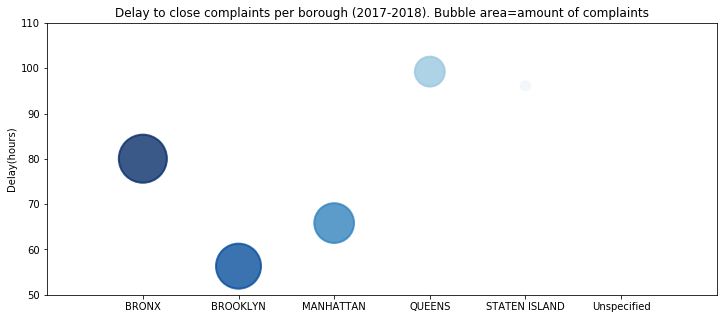

In [20]:
#calculate mean of delay per borough
df_ht_complaint_recent_group=df_ht_complaint_recent[['borough','delay']]
df_Delay=df_ht_complaint_recent_group=df_ht_complaint_recent_group.groupby(['borough'],as_index=False).mean()

Z=df_ht_complaint_recent['borough'].value_counts()
print(' Number of complaints per borough(2017-2018)')
print(Z)

# use the scatter function
W=12
L=5
fig= plt.subplots(figsize=(W,L))
#plt.xlim([9980, 10100])
plt.xlim([-1,6])
plt.ylim([50, 110])
#we add color intensity related to number of complaints in each zip code
plt.scatter(df_Delay['borough'],df_Delay['delay'] , s=Z/40, c=Z*50, cmap="Blues", alpha=0.8,linewidth=2)
plt.title('Delay to close complaints per borough (2017-2018). Bubble area=amount of complaints')
plt.ylabel('Delay(hours)')
plt.show()

By looking at the plot above, we can confirm that indeed Brooklyn complaints are the quickest to be closed

### Based on the above charts, I recommend NYC focuses first on Bronx complaints, since that borough has the 2nd highest amount of complaints (80,000+ vs 90,000+) and in the past 2 years, they are the 2nd longest to solve.
Brooklyn complaints are highest in number, but only by a small fraction and it has improved significantly in reducing solving times in the last couple of years, so it should not be the priority now



We can represent this in a very visual way with a map of NYC with the boroughs shaded according to the delay to solve complaints and bubbles to signal the amount of complaints per borough in the last two years.



In [21]:
#let's first import folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')


Solving environment: done

# All requested packages already installed.

Folium installed and imported!


Now let's import the file with the borough boundaries.
It can be found here:  https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm :
Direct link: https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON
    #key_on=feature.properties.boro_name

In [22]:
#download GEOJSON file from Cloud object storage
Bucket='****'
client_****.download_file(Bucket,Key='Borough Boundaries.geojson',Filename='./Borough Boundaries.geojson')

#borough_geo = open('./Borough Boundaries.geojson','r')
borough_geos=r'Borough Boundaries.geojson' 
#Note that Borough names are Titlecase

In [23]:
#let's also calculate the average of the locations of complaints per borough in order to place the bubble markers in the map

#create dataframes with coordinates of borough complaints, average delays and number of complaints

bo_longitude=df_ht_complaint_recent.groupby(['borough']).mean()['longitude'].to_frame()
bo_longitude.index.name='borough'
bo_longitude=bo_longitude.rename_axis('borough').reset_index()

bo_latitude=df_ht_complaint_recent.groupby(['borough']).mean()['latitude'].to_frame()
bo_latitude.index.name='borough'
bo_latitude=bo_latitude.rename_axis('borough').reset_index()

bo_value=df_ht_complaint_recent.groupby(['borough']).count()['unique_key'].to_frame()
bo_value.index.name='borough'
bo_value=bo_value.rename_axis('borough').reset_index()

bo_delay=df_ht_complaint_recent.groupby(['borough']).mean()['delay'].to_frame()
bo_delay.index.name='borough'
bo_delay=bo_delay.rename_axis('borough').reset_index()

#concatenate dataframes
df_bo=pd.concat([bo_longitude,bo_latitude, bo_value, bo_delay],axis=1)
#remove duplicate columns (street and zip columns)
df_bo= df_bo.loc[:,~df_bo.columns.duplicated()]
#convert to Titlecase
df_bo['borough'] = df_bo['borough'].str.title()

print(df_bo.shape)
df_bo.head()

(6, 5)


borough            longitude             latitude  unique_key  \
0          Bronx              -73.890               40.851       81129   
1       Brooklyn              -73.949               40.656       92546   
2      Manhattan              -73.956               40.799       63121   
3         Queens              -73.844               40.718       35748   
4  Staten Island              -74.112               40.616        3293   

                 delay  
0               80.045  
1               56.322  
2               65.835  
3               99.270  
4               96.122

In [24]:
# define map object
ny_latitude=40.731
ny_longitude=-73.935
ny_bo_map=folium.Map(location=[ny_latitude,ny_longitude],zoom_start=9,width=500,height=400)
# generate choropleth layer using the average delay to close complaints per borough in 2017 and 2018

ny_bo_map.choropleth(
    geo_data=borough_geos,
    data=df_bo,
    columns=['borough','delay'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,legend_name='Average delay to close heating complaints(Hours)',threshold_scale=[46, 58,70,80, 100,108]
    )
# instantiate a feature group for the delays in the dataframe
delays = folium.map.FeatureGroup()

# loop through the boroughs and add each total of complaints per borough to the delays feature group
for lat, lng,val in zip(df_bo.latitude, df_bo.longitude, df_bo.unique_key):
    delays.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=val/5000,
            color='blue',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )

# add incidents to map

ny_bo_map.add_child(delays)
# display map
folium.LayerControl().add_to(ny_bo_map)
ny_bo_map

Looking at the map above, we can easily see how  Bronx has long delays (red shade) and a high number of complaints (second biggest circle)

### We can confirm with the map above that the recommendation is NYC focuses first on Bronx complaints, since that borough has the 2nd highest amount of complaints (80,000+ vs 90,000+) and in the past 2 years, they are the 2nd longest to solve.
Brooklyn complaints are the highest in number, but only by a small fraction and it has improved significantly in reducing solving times in the last couple of years, so it  should not be the priority now

### LETS NOW LOOK AT THE ZIP CODES

When analyzing data per zip code we need to change slightly the approach, since as opposed to boroughs, the number of Zip Codes is much bigger. Let's see first how is the distribution of complaints per zipcode. That is how evenly are complaints distributed accross zip codes.
We will continue to focus on the last couple of years, since these data are the most significant to depict the current situation

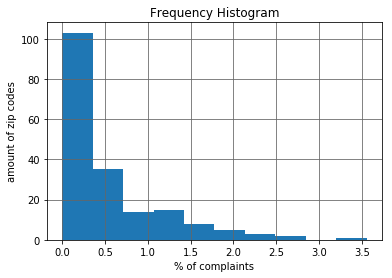

In [25]:
#calculate number of zipcodes

#convert to DFrame
zip_counts = df_ht_complaint_recent['incident_zip'].value_counts(normalize=True).to_frame()
#rename columns
zip_counts.rename(columns={'incident_zip': 'value_counts'}, inplace=True)
#rename index?
#zip_counts.index.name = 'incident_zip'

plt.hist(zip_counts.value_counts*100, bins=10,cumulative=False)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.gca().set(title='Frequency Histogram', ylabel='amount of zip codes',xlabel='% of complaints')
plt.show()


As we can see in the plot above, there are only very few zip codes that received ,each one of them, more than 1% of the complaints, far less with more than 2%.

The question is now, where do we consider the threshold to mark a zipcode as a hotspot? Should we take the top 3, top10, top 20? The ones that receive more than 2% of the total number of complaints?

To help us answer that let's add a column to the zip_counts Data Frame with the cumulative sum of the value counts 

              value_counts         cumulative_%
11226                0.036                3.556
10467                0.028                6.310
10458                0.026                8.925
10453                0.024               11.277
10468                0.022               13.525
10452                0.022               15.677
10031                0.021               17.768
11225                0.020               19.808
10457                0.020               21.825
11213                0.020               23.789


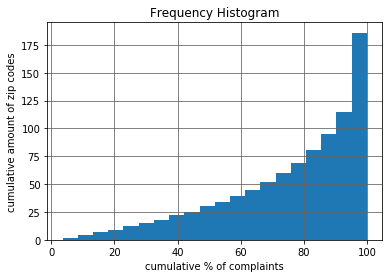

In [26]:
#lets see now the histogram of cumulative complaints per Zip code

#add additional colum with the cumulatie sum of values
zip_counts['cumulative_%']=zip_counts.value_counts.cumsum()*100
print(zip_counts.head(10))


x = zip_counts['cumulative_%']
plt.hist(x, bins=20,cumulative=True)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.gca().set(title='Frequency Histogram', ylabel='cumulative amount of zip codes',xlabel='cumulative % of complaints')
plt.show()

As we can see in the histogram and the DataFrame head above, the top 8 zip codes by number of complaints amount to roughly 20% of the total number of complaints. That is probably a good amount to look further into. Don't forget, that as we did with the boroughs, we want to look also at the delays to close complaints before confirming which Zip Codes should be focused on

In [27]:
#create a new Data Frame with the top 8 zipcodes per number of complaints
zip_list=(zip_counts.head(8).index)
print('Top Zip codes by number of complaints:',zip_list)
df_ht_complaint_top_zip=df_ht_complaint[df_ht_complaint['incident_zip'].isin(zip_list)]
df_ht_complaint_top_zip.head()

Top Zip codes by number of complaints: Index(['11226', '10467', '10458', '10453', '10468', '10452', '10031', '11225'], dtype='object')


created_date  unique_key incident_zip      incident_address  \
137361 2018-10-18 22:40:33    40593851        11226     2116 REGENT PLACE   
194644 2016-12-10 14:21:28    34972062        10452  1001 ANDERSON AVENUE   
194740 2016-12-20 21:23:34    35062675        10452  1001 ANDERSON AVENUE   
194823 2016-12-30 08:49:20    35137977        10452  1001 ANDERSON AVENUE   
196396 2017-06-25 19:10:09    36539955        10458  2326 BATHGATE AVENUE   

            street_name   borough             latitude            longitude  \
137361     REGENT PLACE  BROOKLYN               40.646              -73.959   
194644  ANDERSON AVENUE     BRONX               40.832              -73.927   
194740  ANDERSON AVENUE     BRONX               40.832              -73.927   
194823  ANDERSON AVENUE     BRONX               40.832              -73.927   
196396  BATHGATE AVENUE     BRONX               40.855              -73.891   

               closed_date                delay  created_year  created_month  
137361 2018-10-22 19:29:33               92.000          2018             10  
194644 2016-12-15 08:25:51              114.000          2016             12  
194740 2016-12-27 02:04:27              148.000          2016             12  
194823 2017-01-03 02:09:21               89.000          2016             12  
196396 2017-06-28 02:18:03               55.000          2017              6

In [28]:
#calculate mean of delay per Zip code
df_ht_complaint_group_zip=df_ht_complaint_top_zip[['incident_zip','delay']]
Y=df_ht_complaint_group_zip.groupby(['incident_zip'],as_index=False).mean()
Y.sort_values(['incident_zip'])

#number of complaints per ZIP
Z=df_ht_complaint_top_zip['incident_zip'].value_counts().to_frame()
#rename columns
Z.rename(columns={'incident_zip': 'value_counts'}, inplace=True)
#rename index
Z.index.name = 'incident_zip'
Z.sort_values(['incident_zip'],inplace=True)
Z = Z.rename_axis('incident_zip').reset_index()
#add delays per zip code
Z['delay']=Y['delay']
Z

incident_zip  value_counts                delay
0        10031         14606               78.451
1        10452         15109               79.127
2        10453         18436               77.649
3        10458         19894               76.219
4        10467         21437               79.031
5        10468         17578               78.013
6        11225         13903               69.173
7        11226         23983               68.294

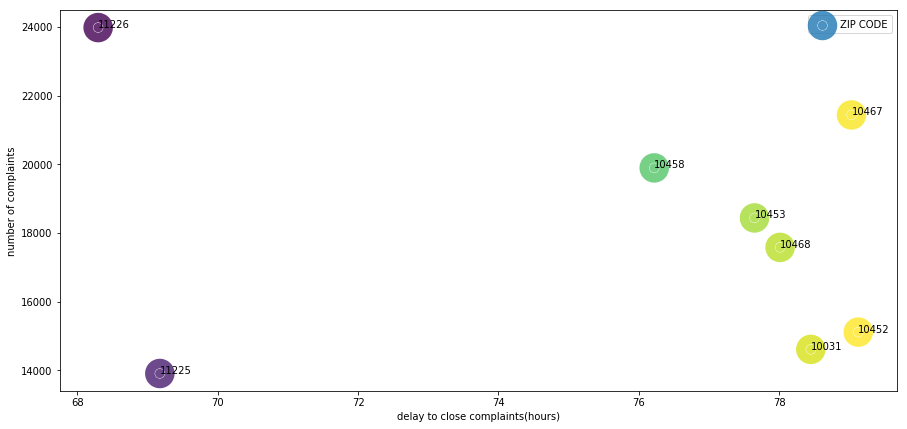

In [29]:
# use the scatter function to plot chart with amount of complaints and average delay to close them per zip code
W=15
L=7
fig= plt.subplots(figsize=(W,L))
#we add color intensity related to number of complaints in each zip code
plt.scatter(Y['delay'], Z['value_counts'],s=90, c=Y['delay'], alpha=0.8,linewidth=20,label='ZIP CODE')
for i in range (0,8):
    xy=(Z.iloc[i,2], Z.iloc[i,1])
    plt.annotate(Z.iloc[i,0],xy)
plt.legend()
plt.ylabel('number of complaints')
plt.xlabel('delay to close complaints(hours)')
plt.show()

We can see in the bubble chart, that, except for 11226 and 11225, there is very little difference among zip codes in terms of delay.Also, 11225 has the lowest amount of complaints of this group, so we should drop it and focus on the rest of the zipcodes: 11226, 10467, 10458, 10453, 10468, 10452 and 10031.



###  I recommend then to focus on 7 Zip codes: 11226, 10453, 10458, 10467,10468 and 10452 and 10031 (Note these receive roughly 18% of the total number of complaints, and most of them belong to the Bronx borough).



As we did with the boroughs, we can create a map with the amount of complaints and delays to solve them by  zipcode to represent these findings more visually.



Now let's import the file with the zipcode boundaries.

#link to zipcodes geojson file: https://github.com/OpenDataDE/State-zip-code-GeoJSON:
#https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json
    #key_on=feature.properties.ZCTA5CE10

In [30]:
#download GEOJSON file from Cloud object storage
Bucket='****'
client_****.download_file(Bucket,Key='ny_new_york_zip_codes_geo.min.json',Filename='./ny_new_york_zip_codes_geo.min.json')

#zip_geo = open('./ny_new_york_zip_codes_geo.min.json','r')
zip_geos=r'ny_new_york_zip_codes_geo.min.json' 
#Note that ZIPCODES names are ?Titlecase

In [31]:

#create dataframes with coordinates of incident_zip complaints, average delays and number of complaints

zip_longitude=df_ht_complaint_recent.groupby(['incident_zip']).mean()['longitude'].to_frame()
zip_longitude.index.name='incident_zip'
zip_longitude=zip_longitude.rename_axis('incident_zip').reset_index()

zip_latitude=df_ht_complaint_recent.groupby(['incident_zip']).mean()['latitude'].to_frame()
zip_latitude.index.name='incident_zip'
zip_latitude=zip_latitude.rename_axis('incident_zip').reset_index()

zip_value=df_ht_complaint_recent.groupby(['incident_zip']).count()['unique_key'].to_frame()
zip_value.index.name='incident_zip'
zip_value=zip_value.rename_axis('incident_zip').reset_index()

zip_delay=df_ht_complaint_recent.groupby(['incident_zip']).mean()['delay'].to_frame()
zip_delay.index.name='incident_zip'
zip_delay=zip_delay.rename_axis('incident_zip').reset_index()

#concatenate dataframes
df_zip=pd.concat([zip_longitude,zip_latitude, zip_value, zip_delay],axis=1)
#remove duplicate columns (street and zip columns)
df_zip= df_zip.loc[:,~df_zip.columns.duplicated()]
#convert to Titlecase
#df_zip['incident_zip'] = df_zip['incident_zip'].str.title()


print(df_zip.shape)
df_zip.tail()

(186, 5)


incident_zip            longitude             latitude  unique_key  \
181        11693              -73.813               40.587         161   
182        11694              -73.831               40.580         407   
183        11697              -73.895               40.566           6   
184        12345              -73.942               40.818           1   
185            n                  nan                  nan        4118   

                   delay  
181              106.043  
182              102.432  
183              102.167  
184               57.000  
185               49.376

In [32]:
#drop complaints with no zip
df_zip=df_zip[df_zip.incident_zip!='n']
#df_zip.drop(['n'],axis=0,inplace=True)
df_zip.tail()

incident_zip            longitude             latitude  unique_key  \
180        11692              -73.793               40.593         361   
181        11693              -73.813               40.587         161   
182        11694              -73.831               40.580         407   
183        11697              -73.895               40.566           6   
184        12345              -73.942               40.818           1   

                   delay  
180              106.812  
181              106.043  
182              102.432  
183              102.167  
184               57.000

In [33]:
# define the NY map centered with a high zoom level
ny_latitude=40.731
ny_longitude=-73.935
ny_zip_map=folium.Map(location=[ny_latitude,ny_longitude],zoom_start=10,width=500,height=500)
ny_zip_map

# generate choropleth map using the total number of complaints per borough in 2017 and 2018

#ny_zip_map.choropleth(
#    geo_data=zip_geos,
#    data=df_zip,
#    columns=['incident_zip','delay'],
#    key_on='feature.properties.ZCTA5CE10',
#    fill_color='YlOrRd',
#    fill_opacity=0.7, 
#   line_opacity=0.2,legend_name='Amount of heating complaints per zipcode(2017-2018)',threshold_scale=[10,75, 100, 250]
#    )

# instantiate a feature group for the delays in the dataframe
counts = folium.map.FeatureGroup()

# loop through the boroughs and add each total of complaints per borough to the delays feature group
for lat, lng,val in zip(df_zip.latitude, df_zip.longitude, df_zip.unique_key):
    counts.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=val/1500,
            color='blue',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )

# add incidents to map

ny_zip_map.add_child(counts)
# display map
folium.LayerControl().add_to(ny_zip_map)
ny_zip_map

As a matter of fact, the above map doesn't include the choropleth, because of filesize issues: Watson Studio won't allow to upload notebooks bigger than 50mb, so I had to remove the choropleth.However, I left the code needed in the cell above in the form of comments and I am including below a snapshot of how the interactive map with the choropleth layer would look like:


In [34]:
# The code was removed by Watson Studio for sharing.

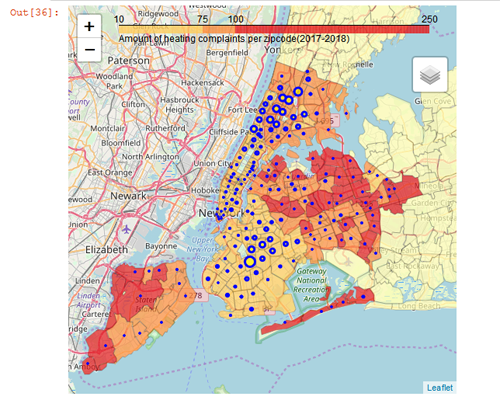

In [35]:
#download image file from Cloud object storage
Bucket='****'
client_****.download_file(Bucket,Key='zip_choroplethsm.png',Filename='./zip_choroplethsm.png')
from IPython.display import Image
Image(filename="zip_choroplethsm.png")

We can see how this map supports our previous findings and is very helpful to navigate through the different zipcodes and their values of complaints and delays.
We can also see how it confirms our choice of Bronx as the borough to focus on, since most of the big circles are there, except one that is in Brooklyn. As a matter of fact, Brooklyn, overall has a high number of complaints, butnot so many hotspots, because it is more extense than Bronx.

### LET'S NOW LOOK AT WHAT HAPPENS AT STREET LEVEL

Since a street can go through more than one borough or there can be streets in different boroughs that have the same name, we will look at the value counts of the pairs (street name, Zip code)
Then we can follow a similar approach as with the zip codes: That is to determine first what are the streets that receive the highest amount of complaints and then amongst them, check where the delays to close complaints are significant to determine which ones we should focus on.

Let's see first which are the streets that receive the highest amount of complaints. 

In [36]:
#in the dataframe of complaints of 2017 and 2018, lets create a new column with the street and zipcode
df_ht_complaint_recent['street_and_zip']=df_ht_complaint_recent['street_name']+', '+df_ht_complaint_recent['incident_zip']
df_ht_complaint_recent.head()

created_date  unique_key incident_zip   incident_address  \
46260 2018-08-15 08:34:41    40020899        11433  153-16 SOUTH ROAD   
46262 2018-08-22 18:05:07    40079557        11433  153-16 SOUTH ROAD   
46263 2018-09-08 12:58:14    40228240        11433  153-16 SOUTH ROAD   
46264 2018-09-11 01:46:25    40246970        11433  153-16 SOUTH ROAD   
46313 2018-10-22 11:27:26    40625222        11433  153-16 SOUTH ROAD   

      street_name borough             latitude            longitude  \
46260  SOUTH ROAD  QUEENS               40.696              -73.800   
46262  SOUTH ROAD  QUEENS               40.696              -73.800   
46263  SOUTH ROAD  QUEENS               40.696              -73.800   
46264  SOUTH ROAD  QUEENS               40.696              -73.800   
46313  SOUTH ROAD  QUEENS               40.696              -73.800   

              closed_date                delay  created_year  created_month  \
46260 2019-04-26 12:57:43            6,100.000          2018              8   
46262 2019-04-26 12:57:43            5,922.000          2018              8   
46263 2019-04-26 12:57:43            5,519.000          2018              9   
46264 2019-04-26 12:57:43            5,459.000          2018              9   
46313 2019-04-26 12:57:43            4,465.000          2018             10   

          street_and_zip  
46260  SOUTH ROAD, 11433  
46262  SOUTH ROAD, 11433  
46263  SOUTH ROAD, 11433  
46264  SOUTH ROAD, 11433  
46313  SOUTH ROAD, 11433

In [37]:
#create dataframes with coordinates of street, average delays and number of complaints

st_longitude=df_ht_complaint_recent.groupby(['street_and_zip']).mean()['longitude'].to_frame()
st_longitude.index.name='street_and_zip'
st_longitude=st_longitude.rename_axis('street_and_zip').reset_index()

st_latitude=df_ht_complaint_recent.groupby(['street_and_zip']).mean()['latitude'].to_frame()
st_latitude.index.name='street_and_zip'
st_latitude=st_latitude.rename_axis('street_and_zip').reset_index()

st_delay=df_ht_complaint_recent.groupby(['street_and_zip']).mean()['delay'].to_frame()
st_delay.index.name='street_and_zip'
st_delay=st_delay.rename_axis('street_and_zip').reset_index()

st_value=df_ht_complaint_recent.groupby(['street_and_zip']).count()['unique_key'].to_frame()
st_value.index.name='street_and_zip'
st_value=st_value.rename_axis('street_and_zip').reset_index()

#concatenate dataframes
df_street=pd.concat([st_longitude,st_latitude,st_delay, st_value],axis=1)
#remove duplicate columns (street and zip columns)
df_street = df_street.loc[:,~df_street.columns.duplicated()]
print(df_street.shape)
df_street.head()

(9210, 5)


street_and_zip            longitude             latitude  \
0  1 AVENUE, 10003              -73.985               40.728   
1  1 AVENUE, 10009              -73.985               40.729   
2  1 AVENUE, 10010              -73.979               40.736   
3  1 AVENUE, 10016              -73.973               40.744   
4  1 AVENUE, 10021              -73.957               40.767   

                 delay  unique_key  
0               58.967          92  
1               74.616         159  
2               79.280          25  
3               52.667          27  
4               59.588         102

In [38]:
#let's remove rows without geographical data
df_street=df_street.dropna(subset=['latitude','longitude'],axis=0)

#let's drop streets with less than 600 complaints in 2017-18
df_street=df_street[df_street['unique_key']>= 600]

df_street.shape

(15, 5)

In [39]:
# Make an empty map
NYla=40.731
NYlo=-73.935
ny_st_map=folium.Map(location=[NYla,NYlo],zoom_start=10,width=500,height=600)
 

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the street,zipcode pairs and add each to the incidents feature group
for lat, lng,size in zip(df_street.latitude, df_street.longitude, df_street.unique_key):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=size/80,
            color='blue',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add incidents to map

ny_st_map.add_child(incidents)
folium.LayerControl().add_to(ny_st_map)
ny_st_map
#code to add labels to map
#lats=list(df_street.latitude)
#longs=list(df_street.longitude)
#labels=list(df_street.street_and_zip)
#size=list(df_street.unique_key)

#for lat,long,label in zip(lats,longs,labels):
 #   folium.Marker([lat,long],popup=label,icon=None).add_to(ny_st_map)
#ny_st_map

This map should be enough to mark hotspots (pairs Street, Zipcode) to focus on. However, if we want to filter further, we can use a scatter plot to visualize both longest delays and highest amount of complaints and see if there are any outliers.

In [40]:
#We can easily print the top pairs (streets,ZipCodes) by amount of complaints received during 2017-2018
df_street.rename(columns={'unique_key':'amount of complaints received 2017-2018'},inplace=True)
df_street.sort_values(by='amount of complaints received 2017-2018',ascending=False,inplace=True)
df_street


street_and_zip            longitude             latitude  \
6175  LINDEN BOULEVARD, 11226              -73.953               40.652   
6831      OCEAN AVENUE, 11230              -73.956               40.625   
6829      OCEAN AVENUE, 11226              -73.960               40.647   
2931    BOYNTON AVENUE, 10472              -73.877               40.825   
3044          BROADWAY, 10031              -73.951               40.826   
7317  ROCKAWAY PARKWAY, 11212              -73.921               40.662   
3648    DECATUR AVENUE, 10467              -73.874               40.876   
6592     MORRIS AVENUE, 10468              -73.898               40.865   
5468   GRAND CONCOURSE, 10468              -73.892               40.868   
6837     OCEAN PARKWAY, 11218              -73.974               40.642   
5462   GRAND CONCOURSE, 10451              -73.924               40.825   
7544        SHORE ROAD, 11209              -74.038               40.617   
5467   GRAND CONCOURSE, 10458              -73.892               40.869   
8032  VALENTINE AVENUE, 10458              -73.894               40.864   
3876  EAST   21 STREET, 11226              -73.959               40.647   

                    delay  amount of complaints received 2017-2018  
6175               46.297                                     1021  
6831               50.822                                      951  
6829               47.775                                      912  
2931               44.910                                      908  
3044               57.134                                      881  
7317               51.710                                      835  
3648               71.184                                      821  
6592               79.003                                      790  
5468               69.627                                      689  
6837               54.515                                      664  
5462               59.339                                      655  
7544               36.749                                      629  
5467               67.814                                      618  
8032               84.751                                      611  
3876               48.087                                      608

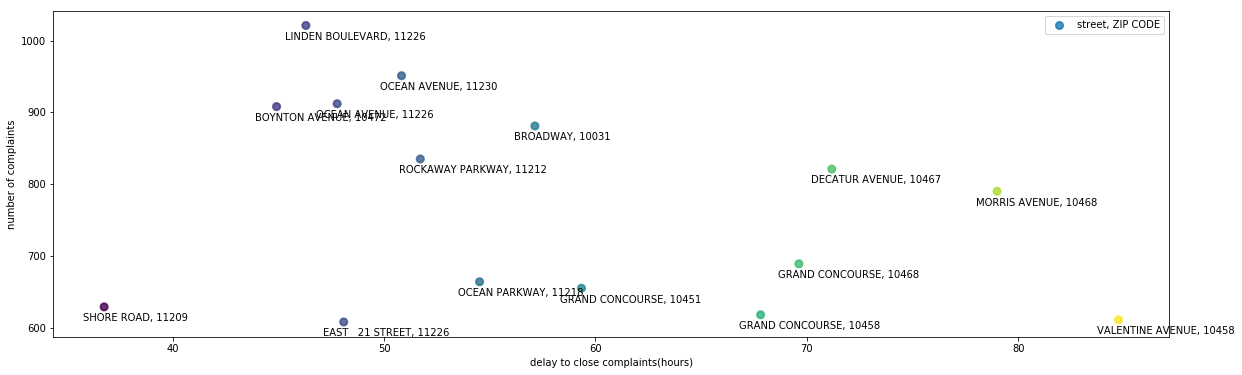

In [41]:
# use the scatter function to plot chart with amount of complaints and average delay to close them per zip code
W=20
L=6
fig= plt.subplots(figsize=(W,L))
#we add color intensity related to number of complaints in each zip code
plt.scatter(df_street['delay'], df_street['amount of complaints received 2017-2018'],s=50, c=df_street['delay'], alpha=0.8,linewidth=2,label='street, ZIP CODE')
for i in range(0,15):
    xy=(df_street.iloc[i,3]-1,df_street.iloc[i,4]-20)
    plt.annotate(df_street.iloc[i,0],xy)
plt.legend()
plt.ylabel('number of complaints')
plt.xlabel('delay to close complaints(hours)')
plt.show()

###  I recommend to focus on all the hotspots in the list above with the exception of Shore Road an East 21 street which have the lowest amount of complaints and shortest delays.

Note also how ,consistent with our analysis of hot ZipCodes, some of the areas in the list above, are actually in some of the Zipcodes that we identified before (11226, 10467 10468, 10458 and 10031)

### ADDITIONAL DETAIL: HEAT MAP

Note how during our analysis at street level we average the location of all complaints per street name and zip code to produce a folium map.

We can however use folium.HeatMap to produce a map with a higher level of precision which can be very powerful to look for hotspots.

In [51]:
#let's go back to our dataframe with the 2017-2018 complaints data and remove rows without geographical data
df_ht_complaint_geo=df_ht_complaint_recent[::]
df_ht_complaint_geo=df_ht_complaint_geo.dropna(subset=['latitude','longitude'],axis=0)
#lets change incident_zip type as string
df_ht_complaint_geo[['incident_zip']]=df_ht_complaint_geo[['incident_zip']].astype(str)
#let's focus purely on data from last year in order to reduce the size (submission in edX has to weigh below 10mb)
df_ht_complaint_geo = df_ht_complaint_geo[df_ht_complaint_geo['created_year'].isin(['2018'])]
# get the first 80000 rows in the  dataframe (submission in edX has to weigh below 10mb)
limit = 80000
df_ht_complaint_geo = df_ht_complaint_geo.iloc[0:limit,:]

df_ht_complaint_geo.shape

(80000, 13)

In [48]:
from folium import plugins
from folium.plugins import HeatMap


In [52]:
#let's create a heatmap of NYC

# Make an empty map
NYla=40.731
NYlo=-73.935
ny_ht_map=folium.Map(location=[NYla,NYlo],zoom_start=10,width=400,height=600)
 
# extract lat, lon, and magnitude for the folium heatmap
hm_wide = HeatMap( list(zip(df_ht_complaint_geo.latitude.values, df_ht_complaint_geo.longitude.values)),min_opacity=0.01,max_val=100,radius=2.55, blur=5,max_zoom=4,gradient={.5: 'lime', .75: 'yellow',.9: 'red'})
ny_ht_map.add_child(hm_wide)
folium.LayerControl().add_to(ny_ht_map)
ny_ht_map


We can see how the interactive heatmap is consistent with the maps we created above, however this is a more powerful tool as we can zoom to a higher level of detail to identify hotspots 

#  Concluding Remarks:  Given the above analysis it makes sense for the DHPD in NYC to first focus on solving Heating complaints in Bronx borough because of the amount of complaints placed and the delay it takes to close them 

#  Additionally I would also give special attention to Zip Codes 11226, 10467, 10458, 10453, 10468, 10452 and 10031. (Note these 7 receive around 18% of the total number of complaints).

#  At street level, please use the list and map of hotspots provided above. A heatmap tool is included for more detail analysis